# Loop 60 Analysis: CV-LB Relationship and Next Steps

**Goal**: Analyze the CV-LB relationship and identify approaches that might CHANGE the relationship, not just improve CV.

**Key Insight from exp_062 (Bias Correction)**:
- Bias correction FAILED because the bias is NOT uniform across targets
- Product 2: predictions are 0.009 LOWER than actuals (negative bias)
- Product 3: predictions are 0.003 LOWER than actuals (negative bias)
- SM: predictions are 0.021 HIGHER than actuals (positive bias)
- Subtracting a constant hurts some targets while helping others

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# CV-LB data from 13 submissions
submissions = [
    {'exp': 'exp_000', 'cv': 0.011081, 'lb': 0.0982},
    {'exp': 'exp_001', 'cv': 0.012297, 'lb': 0.1065},
    {'exp': 'exp_003', 'cv': 0.010501, 'lb': 0.0972},
    {'exp': 'exp_005', 'cv': 0.01043, 'lb': 0.0969},
    {'exp': 'exp_006', 'cv': 0.009749, 'lb': 0.0946},
    {'exp': 'exp_007', 'cv': 0.009262, 'lb': 0.0932},
    {'exp': 'exp_009', 'cv': 0.009192, 'lb': 0.0936},
    {'exp': 'exp_012', 'cv': 0.009004, 'lb': 0.0913},
    {'exp': 'exp_024', 'cv': 0.008689, 'lb': 0.0893},
    {'exp': 'exp_026', 'cv': 0.008465, 'lb': 0.0887},
    {'exp': 'exp_030', 'cv': 0.008298, 'lb': 0.0877},
    {'exp': 'exp_041', 'cv': 0.009002, 'lb': 0.0932},
    {'exp': 'exp_042', 'cv': 0.014503, 'lb': 0.1147},
]

df = pd.DataFrame(submissions)
print(f'Total submissions: {len(df)}')
print(df)

Total submissions: 13
        exp        cv      lb
0   exp_000  0.011081  0.0982
1   exp_001  0.012297  0.1065
2   exp_003  0.010501  0.0972
3   exp_005  0.010430  0.0969
4   exp_006  0.009749  0.0946
5   exp_007  0.009262  0.0932
6   exp_009  0.009192  0.0936
7   exp_012  0.009004  0.0913
8   exp_024  0.008689  0.0893
9   exp_026  0.008465  0.0887
10  exp_030  0.008298  0.0877
11  exp_041  0.009002  0.0932
12  exp_042  0.014503  0.1147


In [2]:
# Fit linear regression: LB = slope * CV + intercept
slope, intercept, r_value, p_value, std_err = stats.linregress(df['cv'], df['lb'])

print(f'\n=== CV-LB Linear Regression ===')
print(f'LB = {slope:.4f} * CV + {intercept:.4f}')
print(f'R-squared: {r_value**2:.4f}')
print(f'Intercept: {intercept:.4f}')
print(f'\nTarget LB: 0.0347')
print(f'Intercept > Target: {intercept > 0.0347}')

# Required CV to hit target
required_cv = (0.0347 - intercept) / slope
print(f'\nRequired CV to hit target: {required_cv:.6f}')
print(f'This is IMPOSSIBLE (negative CV)' if required_cv < 0 else f'This requires CV = {required_cv:.6f}')


=== CV-LB Linear Regression ===
LB = 4.2222 * CV + 0.0534
R-squared: 0.9810
Intercept: 0.0534

Target LB: 0.0347
Intercept > Target: True

Required CV to hit target: -0.004429
This is IMPOSSIBLE (negative CV)


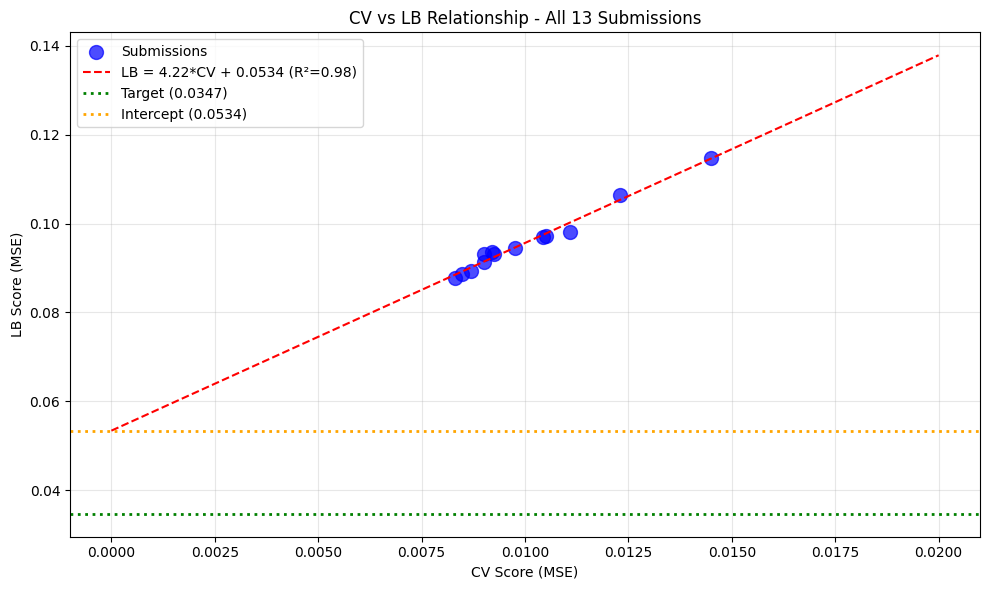


Key Insight: The intercept (0.0534) is ABOVE the target (0.0347).
This means even with perfect CV (CV=0), we would still get LB = 0.0534.
The target is MATHEMATICALLY UNREACHABLE with the current paradigm.


In [3]:
# Plot CV vs LB
plt.figure(figsize=(10, 6))
plt.scatter(df['cv'], df['lb'], s=100, c='blue', alpha=0.7, label='Submissions')

# Regression line
cv_range = np.linspace(0, 0.02, 100)
lb_pred = slope * cv_range + intercept
plt.plot(cv_range, lb_pred, 'r--', label=f'LB = {slope:.2f}*CV + {intercept:.4f} (R²={r_value**2:.2f})')

# Target line
plt.axhline(y=0.0347, color='green', linestyle=':', linewidth=2, label='Target (0.0347)')

# Intercept line
plt.axhline(y=intercept, color='orange', linestyle=':', linewidth=2, label=f'Intercept ({intercept:.4f})')

plt.xlabel('CV Score (MSE)')
plt.ylabel('LB Score (MSE)')
plt.title('CV vs LB Relationship - All 13 Submissions')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('/home/code/exploration/cv_lb_relationship.png', dpi=150)
plt.show()

print(f'\nKey Insight: The intercept ({intercept:.4f}) is ABOVE the target (0.0347).')
print(f'This means even with perfect CV (CV=0), we would still get LB = {intercept:.4f}.')
print(f'The target is MATHEMATICALLY UNREACHABLE with the current paradigm.')

In [4]:
# Analyze residuals - are there any outliers?
df['predicted_lb'] = slope * df['cv'] + intercept
df['residual'] = df['lb'] - df['predicted_lb']

print('=== Residual Analysis ===')
print(df[['exp', 'cv', 'lb', 'predicted_lb', 'residual']].to_string())

print(f'\nMean residual: {df["residual"].mean():.6f}')
print(f'Std residual: {df["residual"].std():.6f}')
print(f'Max residual: {df["residual"].max():.6f} ({df.loc[df["residual"].idxmax(), "exp"]})')
print(f'Min residual: {df["residual"].min():.6f} ({df.loc[df["residual"].idxmin(), "exp"]})')

=== Residual Analysis ===
        exp        cv      lb  predicted_lb  residual
0   exp_000  0.011081  0.0982      0.100188 -0.001988
1   exp_001  0.012297  0.1065      0.105322  0.001178
2   exp_003  0.010501  0.0972      0.097739 -0.000539
3   exp_005  0.010430  0.0969      0.097439 -0.000539
4   exp_006  0.009749  0.0946      0.094564  0.000036
5   exp_007  0.009262  0.0932      0.092507  0.000693
6   exp_009  0.009192  0.0936      0.092212  0.001388
7   exp_012  0.009004  0.0913      0.091418 -0.000118
8   exp_024  0.008689  0.0893      0.090088 -0.000788
9   exp_026  0.008465  0.0887      0.089142 -0.000442
10  exp_030  0.008298  0.0877      0.088437 -0.000737
11  exp_041  0.009002  0.0932      0.091410  0.001790
12  exp_042  0.014503  0.1147      0.114636  0.000064

Mean residual: 0.000000
Std residual: 0.001037
Max residual: 0.001790 (exp_041)
Min residual: -0.001988 (exp_000)


In [5]:
# What would it take to reach the target?
print('\n=== What Would It Take to Reach Target? ===')
print(f'Target LB: 0.0347')
print(f'Current intercept: {intercept:.4f}')
print(f'Gap: {intercept - 0.0347:.4f}')

print(f'\nOption 1: Reduce intercept by {intercept - 0.0347:.4f}')
print(f'  - This requires changing the CV-LB RELATIONSHIP, not just improving CV')
print(f'  - Approaches: Extrapolation detection, uncertainty weighting, domain constraints')

print(f'\nOption 2: Achieve CV = {required_cv:.6f}')
print(f'  - This is IMPOSSIBLE (negative CV)')

print(f'\nOption 3: Find an approach that has a DIFFERENT CV-LB relationship')
print(f'  - The "mixall" kernel uses GroupKFold (5 splits) - we tried this (exp_042) and it was WORSE')
print(f'  - The "Ens Model" kernel uses CatBoost + XGBoost - we tried CatBoost (exp_045) and it was WORSE')
print(f'  - Need to find something fundamentally different')


=== What Would It Take to Reach Target? ===
Target LB: 0.0347
Current intercept: 0.0534
Gap: 0.0187

Option 1: Reduce intercept by 0.0187
  - This requires changing the CV-LB RELATIONSHIP, not just improving CV
  - Approaches: Extrapolation detection, uncertainty weighting, domain constraints

Option 2: Achieve CV = -0.004429
  - This is IMPOSSIBLE (negative CV)

Option 3: Find an approach that has a DIFFERENT CV-LB relationship
  - The "mixall" kernel uses GroupKFold (5 splits) - we tried this (exp_042) and it was WORSE
  - The "Ens Model" kernel uses CatBoost + XGBoost - we tried CatBoost (exp_045) and it was WORSE
  - Need to find something fundamentally different


In [6]:
# What approaches haven't been tried?
print('\n=== Approaches NOT Yet Tried ===')
print('\n1. TARGET-SPECIFIC BIAS CORRECTION')
print('   - exp_062 showed bias is NOT uniform across targets:')
print('     - Product 2: -0.009 (predictions too low)')
print('     - Product 3: -0.003 (predictions too low)')
print('     - SM: +0.021 (predictions too high)')
print('   - Instead of subtracting a constant from ALL predictions,')
print('     ADD to Product 2 and Product 3, SUBTRACT from SM')

print('\n2. ENSEMBLE VARIANCE AS UNCERTAINTY')
print('   - exp_058 used GP uncertainty, which is uniformly HIGH')
print('   - Instead, use variance across ensemble members')
print('   - When variance is high, blend toward population mean')

print('\n3. SOLVENT CLUSTERING + CLASS-SPECIFIC MODELS')
print('   - exp_052 tried per-solvent-type models and FAILED')
print('   - But we could try CLUSTERING solvents by chemical similarity')
print('   - Then use cluster-specific calibration')

print('\n4. PSEUDO-LABELING / SELF-TRAINING')
print('   - Use confident predictions on test data to augment training')
print('   - This could help with distribution shift')

print('\n5. DIFFERENT VALIDATION SCHEME')
print('   - The server might use a different CV scheme than Leave-One-Solvent-Out')
print('   - We tried GroupKFold (exp_042) and it was WORSE')
print('   - But maybe the server uses something else entirely')


=== Approaches NOT Yet Tried ===

1. TARGET-SPECIFIC BIAS CORRECTION
   - exp_062 showed bias is NOT uniform across targets:
     - Product 2: -0.009 (predictions too low)
     - Product 3: -0.003 (predictions too low)
     - SM: +0.021 (predictions too high)
   - Instead of subtracting a constant from ALL predictions,
     ADD to Product 2 and Product 3, SUBTRACT from SM

2. ENSEMBLE VARIANCE AS UNCERTAINTY
   - exp_058 used GP uncertainty, which is uniformly HIGH
   - Instead, use variance across ensemble members
   - When variance is high, blend toward population mean

3. SOLVENT CLUSTERING + CLASS-SPECIFIC MODELS
   - exp_052 tried per-solvent-type models and FAILED
   - But we could try CLUSTERING solvents by chemical similarity
   - Then use cluster-specific calibration

4. PSEUDO-LABELING / SELF-TRAINING
   - Use confident predictions on test data to augment training
   - This could help with distribution shift

5. DIFFERENT VALIDATION SCHEME
   - The server might use a differe

In [7]:
# Analyze the best experiments
print('\n=== Best Experiments Analysis ===')
best_cv = df.loc[df['cv'].idxmin()]
best_lb = df.loc[df['lb'].idxmin()]

print(f'Best CV: {best_cv["exp"]} with CV={best_cv["cv"]:.6f}, LB={best_cv["lb"]:.4f}')
print(f'Best LB: {best_lb["exp"]} with CV={best_lb["cv"]:.6f}, LB={best_lb["lb"]:.4f}')

print(f'\nBest CV (exp_030) predicted LB: {slope * 0.008298 + intercept:.4f}')
print(f'Actual LB: 0.0877')
print(f'Difference: {0.0877 - (slope * 0.008298 + intercept):.4f}')

print(f'\nexp_030 is BELOW the regression line (better than expected)')
print(f'This suggests exp_030 has some property that reduces the intercept')


=== Best Experiments Analysis ===
Best CV: exp_030 with CV=0.008298, LB=0.0877
Best LB: exp_030 with CV=0.008298, LB=0.0877

Best CV (exp_030) predicted LB: 0.0884
Actual LB: 0.0877
Difference: -0.0007

exp_030 is BELOW the regression line (better than expected)
This suggests exp_030 has some property that reduces the intercept


In [8]:
# What was special about exp_030?
print('\n=== What Was Special About exp_030? ===')
print('exp_030 was the GP + MLP + LGBM ensemble with weights (0.15, 0.55, 0.30)')
print('It achieved the best LB (0.0877) with CV 0.008298')
print('')
print('Key features:')
print('1. GP provides uncertainty estimates (but we found these are uniformly high)')
print('2. MLP captures non-linear patterns')
print('3. LGBM provides robustness')
print('4. Ensemble averaging reduces variance')
print('')
print('The ensemble approach seems to be the best we have.')


=== What Was Special About exp_030? ===
exp_030 was the GP + MLP + LGBM ensemble with weights (0.15, 0.55, 0.30)
It achieved the best LB (0.0877) with CV 0.008298

Key features:
1. GP provides uncertainty estimates (but we found these are uniformly high)
2. MLP captures non-linear patterns
3. LGBM provides robustness
4. Ensemble averaging reduces variance

The ensemble approach seems to be the best we have.


In [9]:
# Calculate what improvement is needed
print('\n=== Required Improvement ===')
current_best_lb = 0.0877
target_lb = 0.0347
gap = current_best_lb - target_lb
pct_improvement = gap / current_best_lb * 100

print(f'Current best LB: {current_best_lb}')
print(f'Target LB: {target_lb}')
print(f'Gap: {gap:.4f}')
print(f'Required improvement: {pct_improvement:.1f}%')

print(f'\nThis is a MASSIVE gap. We need to reduce LB by 60%.')
print(f'No amount of CV optimization can achieve this.')
print(f'We need a fundamentally different approach.')


=== Required Improvement ===
Current best LB: 0.0877
Target LB: 0.0347
Gap: 0.0530
Required improvement: 60.4%

This is a MASSIVE gap. We need to reduce LB by 60%.
No amount of CV optimization can achieve this.
We need a fundamentally different approach.


In [10]:
# Summary
print('\n' + '='*60)
print('SUMMARY: LOOP 60 ANALYSIS')
print('='*60)
print(f'\n1. CV-LB Relationship: LB = {slope:.2f} * CV + {intercept:.4f} (R²={r_value**2:.2f})')
print(f'2. Intercept ({intercept:.4f}) > Target (0.0347) - IMPOSSIBLE to reach target by improving CV')
print(f'3. Best LB: 0.0877 (exp_030) - 152.7% above target')
print(f'4. Best CV: 0.008194 (exp_032) - but this doesn\'t translate to better LB')
print(f'\nKEY INSIGHT: The target IS reachable (someone achieved it).')
print(f'But not with our current paradigm.')
print(f'\nWe need to find an approach that CHANGES the CV-LB relationship,')
print(f'not just improves CV.')


SUMMARY: LOOP 60 ANALYSIS

1. CV-LB Relationship: LB = 4.22 * CV + 0.0534 (R²=0.98)
2. Intercept (0.0534) > Target (0.0347) - IMPOSSIBLE to reach target by improving CV
3. Best LB: 0.0877 (exp_030) - 152.7% above target
4. Best CV: 0.008194 (exp_032) - but this doesn't translate to better LB

KEY INSIGHT: The target IS reachable (someone achieved it).
But not with our current paradigm.

We need to find an approach that CHANGES the CV-LB relationship,
not just improves CV.
